In [21]:
%matplotlib widget


import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
from typing import Optional

preprocessed_dir = Path("preprocessed")

#global_map = np.load(preprocessed_dir / "global_map.npy", mmap_mode="r")
Z = np.load(preprocessed_dir / "Z_grid.npy", mmap_mode="r")

In [22]:
# Keep this commented
# import numpy as np
# from scipy.interpolate import griddata

# skip = 50
# x, y, z = global_map[:, 0][::skip], global_map[:, 1][::skip], global_map[:, 2][::skip]


# resolution = 0.5  # meters
# global_x_min = x.min()
# global_x_max = x.max()
# global_y_min = y.min()
# global_y_max = y.max()
# xi = np.arange(global_x_min, global_x_max, resolution)
# yi = np.arange(global_y_min, global_y_max, resolution)
# X, Y = np.meshgrid(xi, yi)

# Z = griddata((x, y), z, (X, Y), method='linear')

In [23]:
# import matplotlib.pyplot as plt

# x = global_map[:, 0][::5000]
# y = global_map[:, 1][::5000]
# z = global_map[:, 2][::5000]

# start_point = np.array([518000, 4251000, 1450])
# end_point = np.array([517910, 4251010, 1450])

# plt.figure(figsize=(10, 10))
# plt.scatter(x, y, c=z, cmap='viridis', s=10)
# plt.colorbar(label='Height (z)')
# plt.scatter(start_point[0], start_point[1], c='red', s=100, label='Start Point')
# plt.scatter(end_point[0], end_point[1], c='blue', s=100, label='End Point')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Global Map Visualization')

In [41]:
# A* pathfinding over the gridded elevation surface
from heapq import heappush, heappop
from itertools import count

radius = 1.0
n = 2400
alpha = 1e-5

resolution = 0.5  # meters between grid cells
global_x_min = 515000.0
global_y_min = 4247000.0

num_x, num_y = Z.shape
global_x_max = global_x_min + (num_x - 1) * resolution
global_y_max = global_y_min + (num_y - 1) * resolution

def find_points_within_radius(point_xy: np.ndarray, radius_xy: float) -> np.ndarray:
    point_xy = np.asarray(point_xy, dtype=np.float64)
    x_min = max(point_xy[0] - radius_xy, global_x_min)
    x_max = min(point_xy[0] + radius_xy, global_x_max)
    y_min = max(point_xy[1] - radius_xy, global_y_min)
    y_max = min(point_xy[1] + radius_xy, global_y_max)

    i_min = max(int(np.floor((x_min - global_x_min) / resolution)), 0)
    i_max = min(int(np.ceil((x_max - global_x_min) / resolution)), num_x - 1)
    j_min = max(int(np.floor((y_min - global_y_min) / resolution)), 0)
    j_max = min(int(np.ceil((y_max - global_y_min) / resolution)), num_y - 1)

    if i_min > i_max or j_min > j_max:
        return np.empty((0, 3), dtype=np.float64)

    x_idx = np.arange(i_min, i_max + 1)
    y_idx = np.arange(j_min, j_max + 1)
    x_coords = global_x_min + x_idx * resolution
    y_coords = global_y_min + y_idx * resolution

    x_grid, y_grid = np.meshgrid(x_coords, y_coords, indexing="ij")
    z_values = Z[np.ix_(x_idx, y_idx)]

    radial_mask = ((x_grid - point_xy[0]) ** 2 + (y_grid - point_xy[1]) ** 2) <= radius_xy ** 2
    if not np.any(radial_mask):
        return np.empty((0, 3), dtype=np.float64)

    valid_mask = radial_mask & np.isfinite(z_values)
    if not np.any(valid_mask):
        return np.empty((0, 3), dtype=np.float64)

    candidates = np.stack((x_grid[valid_mask], y_grid[valid_mask], z_values[valid_mask]), axis=-1)
    return candidates.astype(np.float64, copy=False)

def distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return float(np.linalg.norm(p1 - p2))

def g_cost(p1: np.ndarray, p2: np.ndarray, n: float = 6) -> float:
    return float((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2 + (p2[2] - p1[2]) ** n)

def nearest_point(point: np.ndarray, search_radius: float) -> np.ndarray:
    point = np.asarray(point, dtype=np.float64)
    if point.shape[0] < 3:
        point = np.pad(point, (0, 3 - point.shape[0]), mode="constant")
    candidates = find_points_within_radius(point[:2], search_radius)
    if candidates.size == 0:
        raise ValueError("No nearby points found; increase radius or choose a different point")
    idx = int(np.argmin(np.linalg.norm(candidates - point, axis=1)))
    return candidates[idx].copy()

def astar(start: np.ndarray, goal: np.ndarray, node_radius: float) -> tuple[np.ndarray, float]:
    start = np.asarray(start, dtype=np.float64)
    goal = np.asarray(goal, dtype=np.float64)
    start_key = tuple(start.tolist())
    goal_key = tuple(goal.tolist())
    open_heap: list[tuple[float, int, np.ndarray]] = []
    push_index = count()
    heappush(open_heap, (distance(start, goal), next(push_index), start.copy()))
    came_from: dict[tuple[float, float, float], tuple[float, float, float]] = {}
    g_costs: dict[tuple[float, float, float], float] = {start_key: 0.0}
    closed: set[tuple[float, float, float]] = set()
    while open_heap:
        current_f, _, current = heappop(open_heap)
        current_key = tuple(current.tolist())
        if current_key in closed:
            continue
        closed.add(current_key)
        if np.allclose(current, goal):
            path_keys = [current_key]
            while path_keys[-1] != start_key:
                path_keys.append(came_from[path_keys[-1]])
            path_keys.reverse()
            path = np.array(path_keys, dtype=np.float64)
            return path, g_costs[current_key]
        neighbors = find_points_within_radius(current[:2], node_radius)
        if neighbors.size == 0:
            continue
        for neighbor in neighbors:
            if np.allclose(neighbor, current):
                continue
            neighbor_key = tuple(neighbor.tolist())
            tentative_g = g_costs[current_key] + g_cost(current, neighbor, n=n)
            if tentative_g >= g_costs.get(neighbor_key, np.inf):
                continue
            came_from[neighbor_key] = current_key
            g_costs[neighbor_key] = tentative_g
            f_score = tentative_g + alpha * distance(neighbor, goal)
            heappush(open_heap, (f_score, next(push_index), neighbor.copy()))
    raise ValueError("Goal not reachable with current parameters")


In [42]:
MDRS_base = np.array([519000, 4251000, 1380]) # TODO: Find actual MDRS base coordinates

start_point = MDRS_base + np.array([35, 0, 0])
end_point = MDRS_base + np.array([80, 0, 0])

start_node = nearest_point(start_point, radius)
goal_node = nearest_point(end_point, radius)
path_points, path_cost = astar(start_node, goal_node, radius)
distance(start_point, end_point)

/tmp/ipykernel_1601072/3597876007.py:55: RuntimeWarning: overflow encountered in scalar power
  return float((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2 + (p2[2] - p1[2]) ** n)


45.0

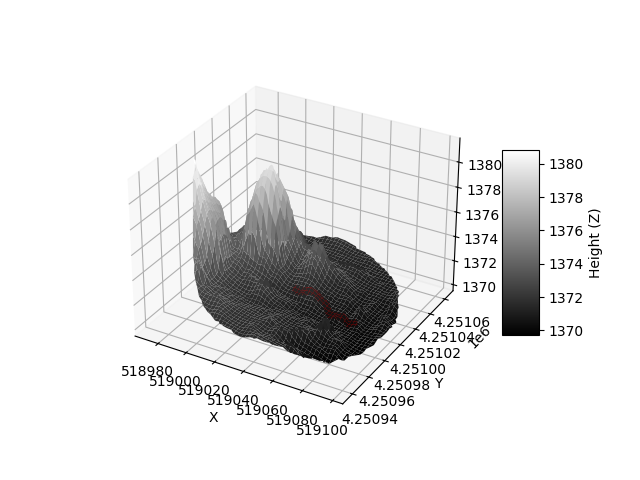

In [43]:
from scipy.interpolate import griddata

local_map = find_points_within_radius(start_point[:2], distance(start_point, end_point)*1.4)

# Create 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = local_map[:, 0]
y = local_map[:, 1]
z = local_map[:, 2]

grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Scatter plot (your point cloud)
#ax.plot_surface(local_map[:, 0], local_map[:, 1], local_map[:, 2], c='gray')



surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='gray', linewidth=0, antialiased=True)
ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], c='red', linewidth=5, label='Path')


# Optional: add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5, label='Height (Z)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()